#References
This notebook can be seen as my implementation of the methods introduced by the following scientific papers:
* "From Group to Individual Labels using Deep Features"
* "BERT: Pre-training of Deep Bidirectional Transformers for
Language Understanding"

In addition to the papers the following tutorial was beneficial:
* https://www.analyticsvidhya.com/blog/2022/01/sentiment-analysis-with-lstm/

Note that the theoritical aspects i used are derived from the above papers.

#Overview
In this notebook we'll build a model for sentiment analysis, we'll test variety of models to get the best possible model. In this notebook we'll be using the correct methodology for a classification driven data mining project, in addition we'll explain every step to get some intuition behind each step.
We'll use a robust method to fight label noise problem that can occur in the instance level classification cases.

In order to demonstrate the approach validity, we'll experement it using these three large review data sets:
* Movie reviews from IMDB.
* Restaurant reviews from Yelp
* Product reviews from Amazon.

## Importing necessery libraries

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%cd /content/drive/MyDrive/Data

/content/drive/MyDrive/Data


In [4]:
!ls

amazon_cells_labelled.txt  imdb_labelled.txt  yelp_labelled.txt


In [5]:
import warnings
warnings.filterwarnings("ignore")

In [101]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Bidirectional, LSTM, Dense

## Exploratory Data Analysis

This section is going to contain simple code to understand data to get confortable with what we're working on.

First we'll construct thee pandas data frames from the data we have

In [7]:
imdb_data = pd.read_csv("imdb_labelled.txt", delimiter='\t', header=None, names=["text", "sentiment"])
yelp_data = pd.read_csv("yelp_labelled.txt", delimiter='\t', header=None, names=["text", "sentiment"])
amazon_data = pd.read_csv("amazon_cells_labelled.txt", delimiter='\t', header=None, names=["text", "sentiment"])

In [8]:
imdb_data.head()

,text,sentiment
0,"A very, very, very slow-moving, aimless movie ...",0
1,Not sure who was more lost - the flat characte...,0
2,Attempting artiness with black & white and cle...,0
3,Very little music or anything to speak of.,0
4,The best scene in the movie was when Gerardo i...,1


Let's explore primarly our data, we can do that by displaying the first raw of each dataset.

In [9]:
yelp_data.head()

,text,sentiment
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


In [23]:
amazon_data.head()

,text,sentiment
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great.,1


It's worth taking time to ask some relevant questions about our data. This is going to make the project more fluid and the data understanding more straightforward.

In [18]:
Datasets = {"Imdb": imdb_data, "Amazon": amazon_data, "Yelp": yelp_data}

In [32]:
def Data_Info(Datasets):
  for Dataset in Datasets:
    print("Size of the " + Dataset + "Dataset is: "+ str(Datasets[Dataset].shape[0]))
    print(Datasets[Dataset].info(), "\n")
  for Dataset in Datasets:
    print("Missing values for ", Dataset, ": \n", Datasets[Dataset].isna().sum())
Data_Info(Datasets=Datasets)

Size of the ImdbDataset is: 748
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 748 entries, 0 to 747
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       748 non-null    object
 1   sentiment  748 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 11.8+ KB
None 

Size of the AmazonDataset is: 1000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       1000 non-null   object
 1   sentiment  1000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 15.8+ KB
None 

Size of the YelpDataset is: 1000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       1000 non-null   object
 1   sentiment  1000 non-null   int64 
dt

You see, luckily for us, there 're not any missing values. Another beneficial trick we can do is to see the statistical properties of our data.

In [29]:
for dataset in Datasets:
  print("Some Statistical properties of "+ str(dataset) +": \n")
  print(str(Datasets[dataset].describe()))

Some Statistical properties of Imdb: 

        sentiment
count  748.000000
mean     0.516043
std      0.500077
min      0.000000
25%      0.000000
50%      1.000000
75%      1.000000
max      1.000000
Some Statistical properties of Amazon: 

        sentiment
count  1000.00000
mean      0.50000
std       0.50025
min       0.00000
25%       0.00000
50%       0.50000
75%       1.00000
max       1.00000
Some Statistical properties of Yelp: 

        sentiment
count  1000.00000
mean      0.50000
std       0.50025
min       0.00000
25%       0.00000
50%       0.50000
75%       1.00000
max       1.00000


You have to know that we'll train our model on the whole data so let's build a pandas dataframe containing all data.

In [36]:
amazon_data["source"] = "amazon"
imdb_data["source"] = "imdb"
yelp_data["source"] = "yelp"

In [37]:
data = pd.concat(list(Datasets.values()))
data.head()

,text,sentiment,source
0,"A very, very, very slow-moving, aimless movie ...",0,imdb
1,Not sure who was more lost - the flat characte...,0,imdb
2,Attempting artiness with black & white and cle...,0,imdb
3,Very little music or anything to speak of.,0,imdb
4,The best scene in the movie was when Gerardo i...,1,imdb


Let's test the what we've said on the new data

In [40]:
data.shape

(2748, 3)

In [38]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2748 entries, 0 to 999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       2748 non-null   object
 1   sentiment  2748 non-null   int64 
 2   source     2748 non-null   object
dtypes: int64(1), object(2)
memory usage: 85.9+ KB


In [39]:
data.describe()

,sentiment
count,2748.000000
mean,0.504367
std,0.500072
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


Visualizations: This step will encourage readers to gain more insights frpm the data!

<Axes: >

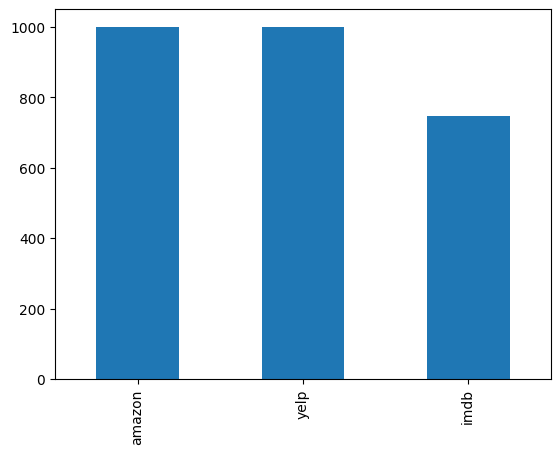

In [60]:
data['source'].value_counts().plot(kind='bar')

Let's see this with a more representative way!

<Axes: ylabel='source'>

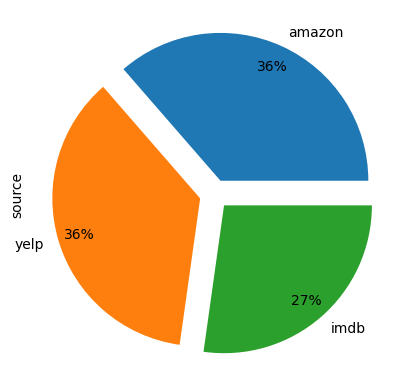

In [50]:
data['source'].value_counts().plot(kind='pie',
                                   autopct='%1.0f%%',
                                   shadow=False,
                                   pctdistance=0.85,
                                   explode = (0.1,0.1,0.1))

<Axes: ylabel='sentiment'>

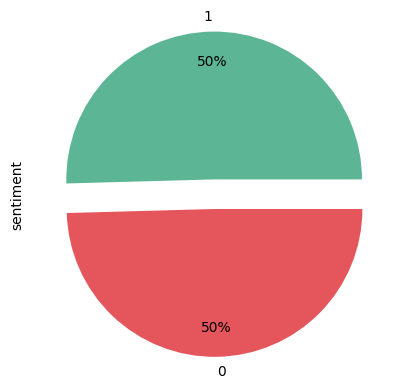

In [56]:
data['sentiment'].value_counts().plot(kind='pie',
                                   autopct='%1.0f%%',
                                   shadow=False,
                                  colors = ['#5cb696','#e4565c'],
                                   pctdistance=0.80,
                                   explode = (0.1, 0.1))

Seems like we've got a ballanced data

## Preprocessing

Like any NLP project we have to find a way to represent words, create a vocabulary and words embeddings for better results. In addition, we'll get to divide data into train and test split.

In [90]:
sentences = data['text'].values
labels = data['sentiment'].values
sentences_train, sentences_test, train_labels, test_labels = train_test_split(sentences,
                                                                              labels,
                                                                               test_size=.25,
                                                                                shuffle=True)

The following code will create a vocabulary and encodes sentences.

In [91]:
vectorizer = CountVectorizer()
vectorizer.fit(sentences_train)
X_train = vectorizer.transform(sentences_train)
X_test = vectorizer.transform(sentences_test)

In [92]:
print(X_train)

  (0, 1543)	1
  (0, 1681)	3
  (0, 2912)	1
  (0, 3354)	1
  (0, 4154)	2
  (0, 4194)	1
  (1, 162)	1
  (1, 305)	1
  (1, 351)	1
  (1, 944)	1
  (1, 1024)	1
  (1, 1379)	1
  (1, 1767)	1
  (1, 1883)	1
  (1, 2034)	1
  (1, 2250)	1
  (1, 2505)	1
  (1, 3354)	1
  (1, 3736)	1
  (1, 3864)	1
  (1, 3880)	1
  (1, 4245)	1
  (1, 4281)	1
  (2, 152)	1
  (2, 222)	1
  :	:
  (2057, 3127)	1
  (2057, 3798)	1
  (2057, 3809)	1
  (2057, 4196)	1
  (2058, 174)	1
  (2058, 1134)	1
  (2058, 1300)	1
  (2058, 2034)	1
  (2058, 2210)	1
  (2058, 2268)	1
  (2058, 2573)	1
  (2058, 2622)	1
  (2058, 3400)	1
  (2058, 3960)	1
  (2059, 65)	1
  (2059, 174)	1
  (2059, 2029)	1
  (2059, 2564)	1
  (2059, 2605)	1
  (2059, 3795)	1
  (2059, 3876)	1
  (2060, 652)	1
  (2060, 999)	1
  (2060, 2661)	1
  (2060, 4277)	1


## Models Building

In the history of NLP, the LSTM model has been resistant for a long time making of it a powerful model and so it's intuitive approach to do is to use it since first it's an Recurrent Neural Network. But before that let's test first a simpler machine learning model let's use Logositic Regression as an example.

In [93]:
classifier = LogisticRegression()
classifier.fit(X_train, train_labels)

LogisticRegression()

In [94]:
accuracy = classifier.score(X_test, test_labels)
accuracy

0.8078602620087336

Let's use now an LSTM network, we'll use a bidirectional LSTM since in a sentence future words can influence past words.

for more infos about the LSTM and how it can be useful against the Vanishing & Exploding Gradients here's my medium article in which where i delve into this specific aspect:

* https://medium.com/@oussamahamdani1718/training-rnns-how-math-saved-the-day-50ee3906bfbf

Here's a simple illustration to gain some intuition about the "Bidirectional RNN":

 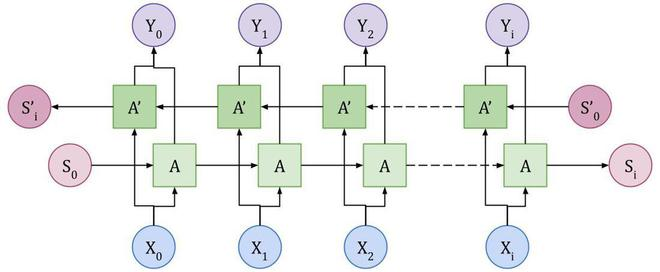

In this section we'll introduce the Dev set also since Deep learning models with their advanced computations can lead to overfitting!

In [144]:
sentences_train, sentences_val, y_train, y_val = train_test_split(sentences, labels, test_size=0.2)
sentences_train, sentences_test, y_train, y_test = train_test_split(sentences_train, y_train, test_size=0.2)

In this section we'll use the word embeddings in order to get good results, word embedding try to capture not only a word representation but also finds a Vector space in which similar words in meaning terms have close representation!

In [145]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(sentences_train)

In [146]:
X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)
X_val = tokenizer.texts_to_sequences(sentences_val)
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 100
maxlen = 100
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)
X_val = pad_sequences(X_val, padding='post', maxlen=maxlen)

In [147]:
LSTM_model = Sequential()
LSTM_model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
LSTM_model.add(Bidirectional(LSTM(50)))
LSTM_model.add(Dense(12, activation='tanh'))
LSTM_model.add(Dense(1, activation='sigmoid'))

In [148]:
LSTM_model.compile(loss='binary_crossentropy',
                    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08),
                     metrics = ["accuracy"]
                   )

In [149]:
LSTM_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 100, 100)          414800    
                                                                 
 bidirectional_7 (Bidirecti  (None, 100)               60400     
 onal)                                                           
                                                                 
 dense_13 (Dense)            (None, 12)                1212      
                                                                 
 dense_14 (Dense)            (None, 1)                 13        
                                                                 
Total params: 476425 (1.82 MB)
Trainable params: 476425 (1.82 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [150]:
num_epochs = 20
history = LSTM_model.fit(X_train,
                          y_train,
                           epochs=num_epochs,
                            verbose=True,
                             batch_size=64,
                             validation_data=(X_val, y_val)
                            )

Epoch 1/20
28/28 [==============================] - 12s 255ms/step - loss: 0.6890 - accuracy: 0.5353 - val_loss: 0.6802 - val_accuracy: 0.5091
Epoch 2/20
28/28 [==============================] - 4s 154ms/step - loss: 0.5715 - accuracy: 0.7560 - val_loss: 0.5165 - val_accuracy: 0.7545
Epoch 3/20
28/28 [==============================] - 4s 151ms/step - loss: 0.2818 - accuracy: 0.9147 - val_loss: 0.4841 - val_accuracy: 0.8091
Epoch 4/20
28/28 [==============================] - 6s 207ms/step - loss: 0.1257 - accuracy: 0.9716 - val_loss: 0.5159 - val_accuracy: 0.8109
Epoch 5/20
28/28 [==============================] - 4s 142ms/step - loss: 0.0696 - accuracy: 0.9898 - val_loss: 0.5749 - val_accuracy: 0.7982
Epoch 6/20
28/28 [==============================] - 4s 151ms/step - loss: 0.0423 - accuracy: 0.9949 - val_loss: 0.6401 - val_accuracy: 0.7873
Epoch 7/20
28/28 [==============================] - 6s 211ms/step - loss: 0.0254 - accuracy: 0.9977 - val_loss: 0.7314 - val_accuracy: 0.7673
Epoch

In [151]:
loss, accuracy = LSTM_model.evaluate(X_train, y_train, verbose=False)
print("Accuray of training data {:.2f}%".format(accuracy*100))
loss, accuracy = LSTM_model.evaluate(X_test, y_test, verbose=False)
print("Accuray of test data: {:.2f} %".format(accuracy*100))

Accuray of training data 99.94%
Accuray of test data: 84.09 %


You see! by selectin the right model and some hyperparameter tuning we have made our model capable of generalize to more unseen cases.